# Temp Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
sns.set_theme()

In [3]:
TEMP_GLOBAL_FILE = 'data/processed/temperature/temp-land-ocean-global.csv'
TEMP_REGION_FILE = 'data/processed/temperature/temp-land-region.csv'
TEMP_COUNTRY_FILE = 'data/processed/temperature/temp-land-country.csv'
DIS_ALL_FILE = 'data/processed/disaster/disaster-all.csv'

In [4]:
# Todo: replace when merging
temp_global = pd.read_csv(TEMP_GLOBAL_FILE)
temp_region = pd.read_csv(TEMP_REGION_FILE)
temp_country = pd.read_csv(TEMP_COUNTRY_FILE)
dis_all = pd.read_csv(DIS_ALL_FILE)

Add smoothing

In [5]:
# applies lowess smoothing to each group
# if no group is supplied lowess will be applied to the whole dataset
def lowess_grouped(data: pd.DataFrame, x_name: str, y_name: str, group_name, frac: float):
    df = data.copy()
    y_name_smoothed = y_name + "_smooth"
    if group_name is not None:
        groups = df[group_name].unique().tolist()
        smoothed_dfs = []
        for group in groups:
            df_by_select_group = df[df[group_name] == group]
            smoothed_df = sm.nonparametric.lowess(df_by_select_group[y_name],df_by_select_group[x_name],frac=frac)
            smoothed_df = pd.DataFrame(smoothed_df)
            smoothed_df.columns = [x_name, y_name_smoothed]
            smoothed_df[x_name] = smoothed_df[x_name].astype(int)
            smoothed_df[group_name] = group
            smoothed_dfs.append(smoothed_df)
        return pd.merge(df,pd.concat(smoothed_dfs), how="left", on=[x_name,group_name])
    else:
        smoothed_df = sm.nonparametric.lowess(df[y_name], df[x_name], frac=frac)
        smoothed_df = pd.DataFrame(smoothed_df)
        smoothed_df.columns = [x_name, y_name_smoothed]
        return pd.merge(df,smoothed_df, how="left", on=x_name)

In [6]:
temp_global = lowess_grouped(temp_global, "year", "temperature_anomaly", None, frac=0.05)
temp_region = lowess_grouped(temp_region, "year", "temperature_anomaly", "region_name", frac=0.05)
temp_country = lowess_grouped(temp_country, "year", "temperature_anomaly", "country_name", frac=0.05)

## Global temperature trend

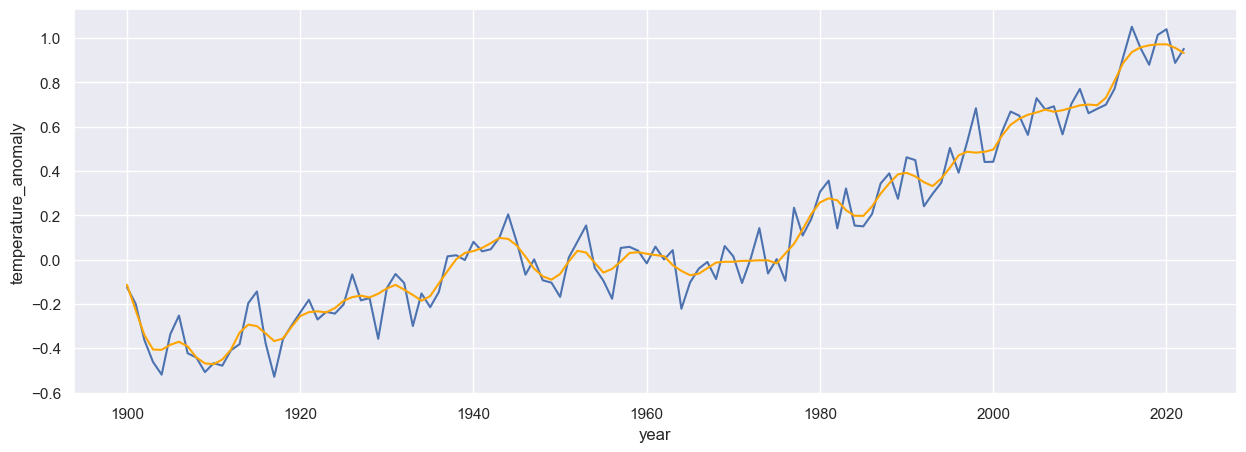

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year", y="temperature_anomaly", data=temp_global)
sns.lineplot(x="year", y="temperature_anomaly_smooth", data=temp_global, color="orange");

In the plot we can observe what seems to be a positive trend for the temperature anomalies, especially in the last 20 years all temperature anomalies have a positive value.

We also want to observe this trend numerically by fitting a linear regression to the data and observing its slope parameter.

In [8]:
# Todo: add new plot with temperature_anomaly and regression line
temp_global_lin_reg = sm.OLS(temp_global['temperature_anomaly'], temp_global['year']).fit()
print(temp_global_lin_reg.summary())

                                 OLS Regression Results                                 
Dep. Variable:     temperature_anomaly   R-squared (uncentered):                   0.089
Model:                             OLS   Adj. R-squared (uncentered):              0.082
Method:                  Least Squares   F-statistic:                              11.96
Date:                 Fri, 20 Jan 2023   Prob (F-statistic):                    0.000751
Time:                         17:53:07   Log-Likelihood:                         -59.800
No. Observations:                  123   AIC:                                      121.6
Df Residuals:                      122   BIC:                                      124.4
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

## Temperature trend per regions

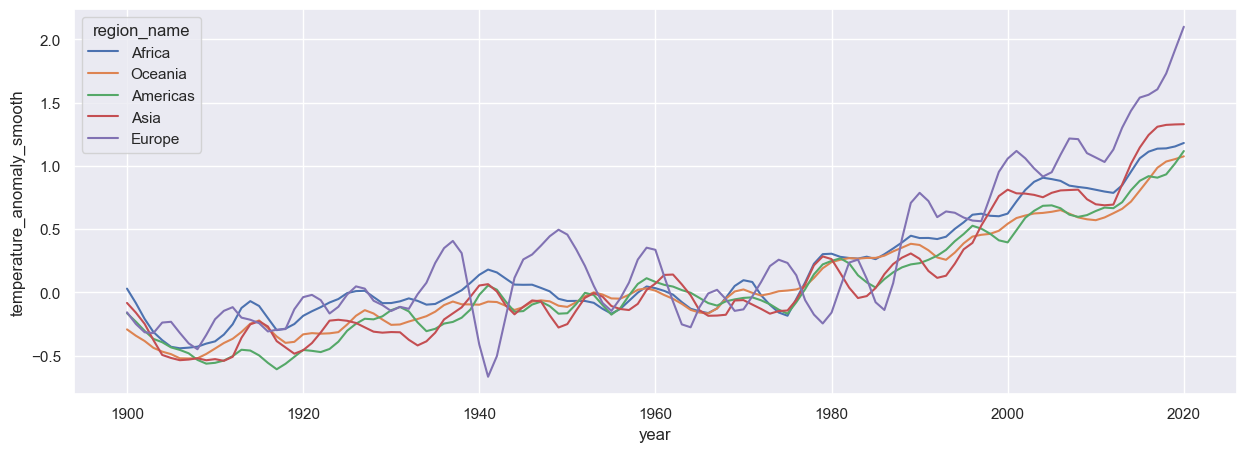

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x="year", y="temperature_anomaly_smooth", hue="region_name", data=temp_region, ax=ax);

=> Europe seems to be more extreme than the rest

## Did some countries have extremer temperature anomalies than others?

### High anomaly in 2020

In [10]:
temp_country[temp_country["year"] == 2020].sort_values(by=["temperature_anomaly_smooth"], ascending=False).head()

,year,country_code,temperature_anomaly,country_name,temperature_anomaly_smooth
27238,2020,LVA,3.315083,Latvia,3.265715
27186,2020,EST,3.403417,Estonia,3.244439
27276,2020,RUS,3.627500,Russia,3.186368
27236,2020,LTU,3.134333,Lithuania,3.181848
27157,2020,BLR,3.101917,Belarus,3.137251


In [11]:
temp_country[temp_country["year"] == 2020].sort_values(by=["temperature_anomaly_smooth"], ascending=False).tail()

,year,country_code,temperature_anomaly,country_name,temperature_anomaly_smooth
27279,2020,SDN,0.528083,Sudan,0.595429
27136,2020,AFG,0.379750,Afghanistan,0.549394
27263,2020,PAK,0.531750,Pakistan,0.492607
27210,2020,IND,0.430750,India,0.485394
27260,2020,NPL,0.323667,Nepal,0.366796


In [12]:
def plot_countries_temp_anomalies(temp_countries):
    fig, ax = plt.subplots(figsize=(15, 5))
    for i,country_code in enumerate(temp_countries):
        temp_selected_country = temp_country[temp_country["country_code"] == country_code]
        selected_country_name = temp_selected_country["country_name"].iloc[0]
        sns.lineplot(x="year",y="temperature_anomaly_smooth",data=temp_selected_country, ax=ax, label=selected_country_name)
    ax.legend();

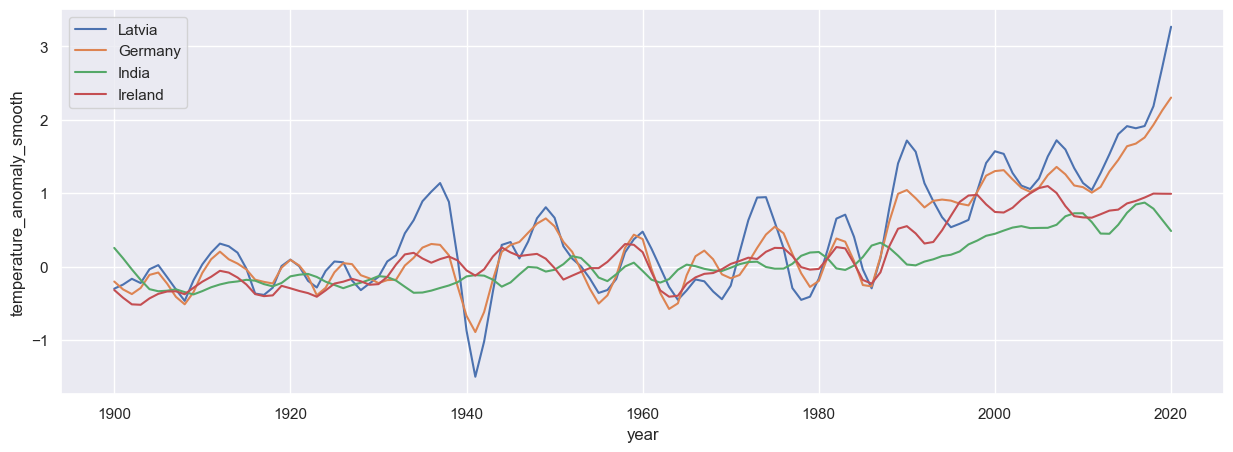

In [13]:
# choose countries that have large increase in temperature_anomaly, and some that have small increase
temp_extreme_countries = ["LVA","DEU","IND","IRL"]
plot_countries_temp_anomalies(temp_extreme_countries)

### Linear regression

In [14]:
temp_regression_countries = []
for country_code in temp_country["country_code"].unique().tolist():
    result = smf.ols(formula="temperature_anomaly ~ year", data=temp_country[temp_country["country_code"] == country_code]).fit()
    temp_regression_countries.append([country_code,result.params["year"]])
temp_regression_countries = pd.DataFrame(temp_regression_countries)
temp_regression_countries.columns = ["country_code","year_slope"]
temp_regression_countries.sort_values(by=["year_slope"],ascending=False)

,country_code,year_slope
135,MNG,0.018051
228,ATA,0.017874
177,SJM,0.017829
106,KGZ,0.016326
104,KAZ,0.016276
...,...,...
185,STP,0.008036
41,COG,0.007833
93,IND,0.007577
129,MEX,0.007145


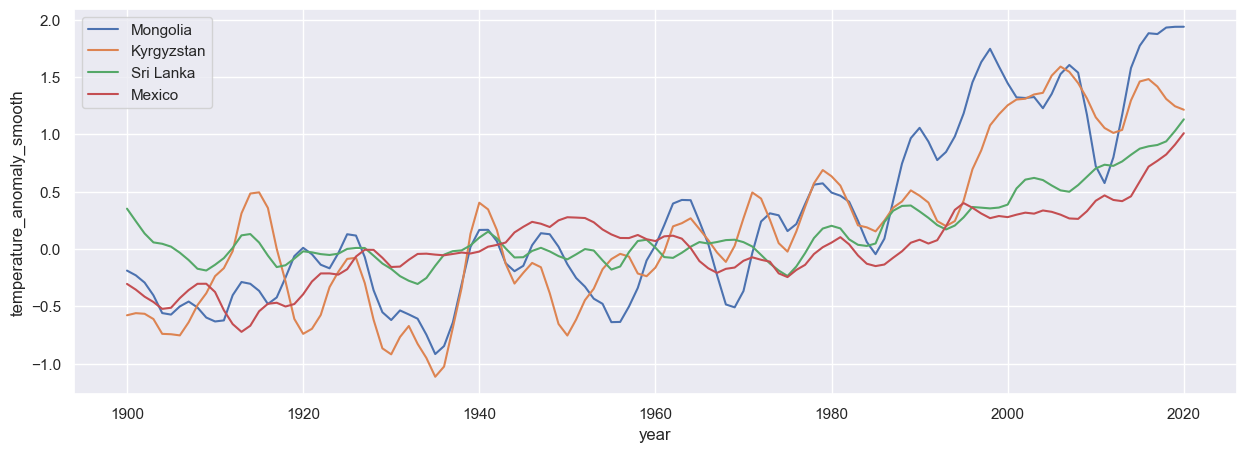

In [15]:
temp_extreme_countries = ["MNG","KGZ","LKA","MEX"]
plot_countries_temp_anomalies(temp_extreme_countries)

=> cant really see something meaningful here

### Outlier count

Yes we can see in the Boxplot that outliers exist.

We want to know at which value we can consider an temperature anomaly to be an outlier.

Therefore we will calculate upper and lower bounds for temperature anomalies using IQR in the following steps.

C:\Users\Sebi\anaconda3\envs\dopp-a2_3-9\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='temperature_anomaly'>

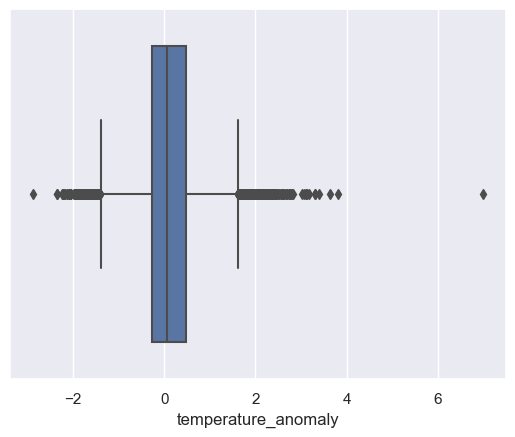

In [16]:
sns.boxplot(temp_country['temperature_anomaly'])

#### Calculate temperature anomaly IQR

In [17]:
temp_anomalies_np_arr = temp_country['temperature_anomaly'].to_numpy()
temp_anomalies_q3 = np.quantile(temp_anomalies_np_arr, 0.75)
temp_anomalies_q1 = np.quantile(temp_anomalies_np_arr, 0.25)
IQR = temp_anomalies_q3 - temp_anomalies_q1
IQR

0.7557916666666666

#### Calculate upper/lower bound for temp anomaly outliers using IQR

In [18]:
temp_anomaly_upper_bound = temp_anomalies_q3 + 1.5 * IQR
temp_anomaly_lower_bound = temp_anomalies_q1 - 1.5 * IQR
print(temp_anomaly_upper_bound)
print(temp_anomaly_lower_bound)

1.6220625
-1.4011041666666666


#### Detect extreme countries counting outliers based on IQR bounds

1. we filter for countries which include temperature anomaly outliers

2. we count the temperature anomaly outliers for each country and sort them by outlier count

In [19]:
temp_countries_anomaly_outlier = temp_country[(temp_country['temperature_anomaly'] >= temp_anomaly_upper_bound)
                                              | (temp_country['temperature_anomaly'] <= temp_anomaly_lower_bound)][['country_code', 'temperature_anomaly']]

temp_countries_anomaly_outlier = temp_countries_anomaly_outlier.groupby(['country_code']).count().sort_values(['temperature_anomaly'], ascending=False)
temp_countries_anomaly_outlier.head(5)

,temperature_anomaly
country_code,
SJM,32
FIN,29
EST,25
LVA,22
LTU,22


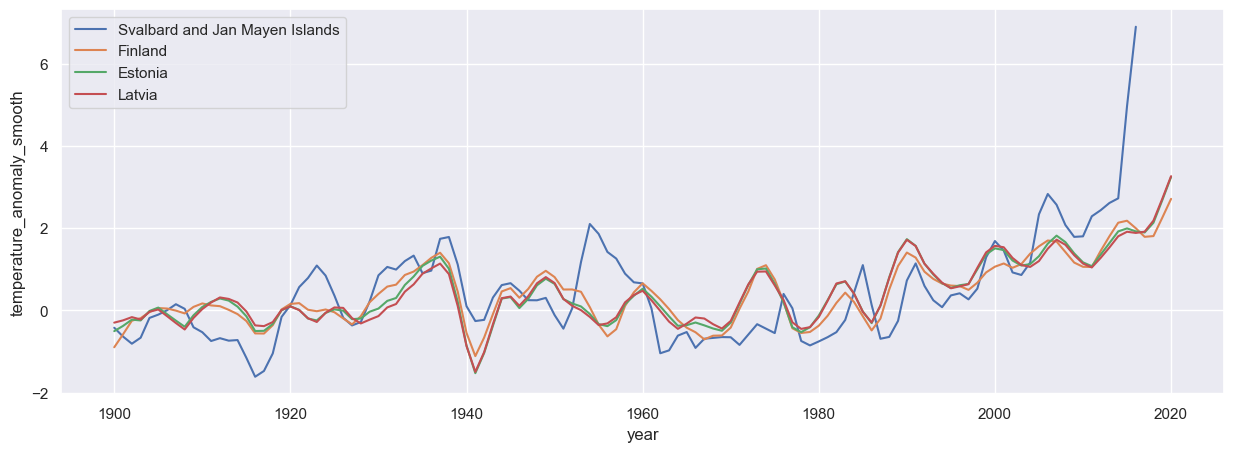

In [20]:
temp_extreme_countries = ["SJM","FIN","EST","LVA"]
plot_countries_temp_anomalies(temp_extreme_countries)

The Temperature anomalies of the most extreme countries (SJM, FIN, EST, LVA), based on our IQR outlier detection, are show in the plot above. We find that the temperature anomalies of the countries Finland, Estonia and Lativa, look similar which is probably due to their geographical closeness. The Svalbard and Jan Mayen Islands are located in the Arctic about midway between mainland Norway and the North Pole and show some extreme temperature anomalies, of up to 6 degrees after year 2000.

### Observation of a correlation between natural disasters and climate change

We are going to observe if a correlation between natural disasters and climate change exist. To do so we will create a new dataframe containing natural disaster deaths and temperature anomalies on a global level.

Filter for interesting disaster types

In [21]:
keep_types = ['Drought', 'Earthquake', 'Storm', 'Flood', 'Wildfire', 'Extreme temperature ']
dis_interesting_types = dis_all.loc[dis_all['type'].isin(keep_types),:]

#### Correlation of natural disaster deaths with temperature anomalies

Group deaths per disaster type per year to dis_global_deaths_yearly

In [22]:
dis_global_yearly_deaths = dis_interesting_types[['year', 'type', 'deaths']].groupby(['year', 'type']).agg('sum').reset_index()
dis_global_yearly_deaths_wide = pd.pivot(dis_global_yearly_deaths, index='year', columns='type', values='deaths')
dis_global_yearly_deaths_wide.head(3)

type,Drought,Earthquake,Extreme temperature,Flood,Storm,Wildfire
year,,,,,,
1900,1261000.0,140.0,NaN,300.0,6000.0,NaN
1901,NaN,18.0,NaN,NaN,NaN,NaN
1902,NaN,9148.0,NaN,NaN,600.0,NaN


Reformat replace NaN values with 0, rename columns and add _deaths suffix to column names

In [23]:
def reformatDisGlobalYearlyWide(dis_global_yearly_wide, suffix):
    dis_global_yearly_wide = dis_global_yearly_wide.fillna(0)
    dis_global_yearly_wide = dis_global_yearly_wide.astype('int32')
    dis_global_yearly_wide.columns = [c.replace(' ', '_').lower() for c in dis_global_yearly_wide.columns]
    dis_global_yearly_wide.rename(columns={'extreme_temperature_': 'extreme_temperature', 'mass_movement_(dry)': 'mass_movement_dry'}, inplace=True)
    dis_global_yearly_wide = dis_global_yearly_wide.add_suffix(suffix)
    dis_global_yearly_wide.reset_index(inplace=True)
    return dis_global_yearly_wide

In [24]:
dis_global_yearly_deaths_wide = reformatDisGlobalYearlyWide(dis_global_yearly_deaths_wide, "_deaths")

Add global temperature anomaly values

In [25]:
dis_global_yearly_deaths_wide['temperature_anomaly'] = temp_global['temperature_anomaly']
dis_global_yearly_deaths_wide.head(3)

,year,drought_deaths,earthquake_deaths,extreme_temperature_deaths,flood_deaths,storm_deaths,wildfire_deaths,temperature_anomaly
0,1900,1261000,140,0,300,6000,0,-0.125167
1,1901,0,18,0,0,0,0,-0.199333
2,1902,0,9148,0,0,600,0,-0.362167


Plot correlations of temperature anomalies and total disaster deaths

In [33]:
def plotTempDisCorrelation(corr):
    corr.sort_values(by='temperature_anomaly', inplace=True, ascending=False)
    corr = corr.T
    cmap = sns.color_palette("rocket", as_cmap=True)
    fig, ax = plt.subplots(figsize=(12,1))
    sns.heatmap(corr,annot=True,vmin=0, vmax=1,cmap=cmap, annot_kws={"size": 8},ax=ax)
    ax.set_title("Correlation Matrix", y=1);
    return

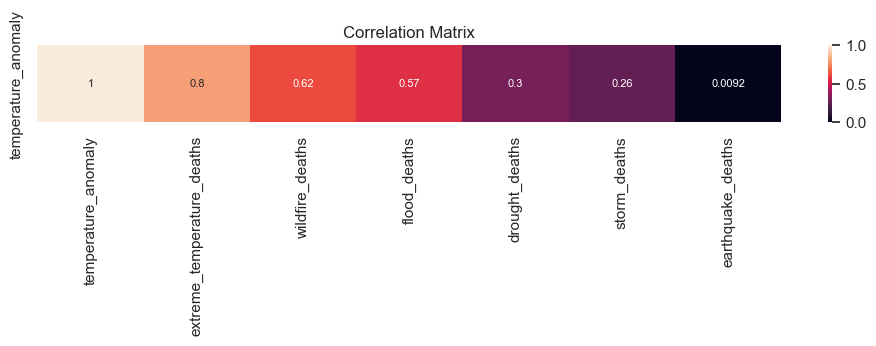

In [34]:
dis_global_yearly_count_wide_corr = dis_global_yearly_deaths_wide.drop('year', axis=1).corr(method='spearman')[['temperature_anomaly']]
plotTempDisCorrelation(dis_global_yearly_count_wide_corr)

#### Correlation of natural disaster occurrences with temperature anomalies

Group disaster types and year and count occurrences

In [28]:
dis_global_yearly_count = dis_interesting_types[['year', 'type']].groupby(['year', 'type']).size().reset_index()
dis_global_yearly_count.rename({0: 'occurrences'}, axis=1, inplace=True)
dis_global_yearly_count_wide = pd.pivot(dis_global_yearly_count, index='year', columns='type', values='occurrences')

Reformat column names and add _occurrences suffix to column names

In [29]:
dis_global_yearly_count_wide = reformatDisGlobalYearlyWide(dis_global_yearly_count_wide, "_occurrences")
dis_global_yearly_count_wide.head(3)

,year,drought_occurrences,earthquake_occurrences,extreme_temperature_occurrences,flood_occurrences,storm_occurrences,wildfire_occurrences
0,1900,2,1,0,1,1,0
1,1901,0,1,0,0,0,0
2,1902,0,4,0,0,1,0


Add global temperature anomaly values

In [30]:
dis_global_yearly_count_wide['temperature_anomaly'] = temp_global['temperature_anomaly']
dis_global_yearly_count_wide.head(3)

,year,drought_occurrences,earthquake_occurrences,extreme_temperature_occurrences,flood_occurrences,storm_occurrences,wildfire_occurrences,temperature_anomaly
0,1900,2,1,0,1,1,0,-0.125167
1,1901,0,1,0,0,0,0,-0.199333
2,1902,0,4,0,0,1,0,-0.362167


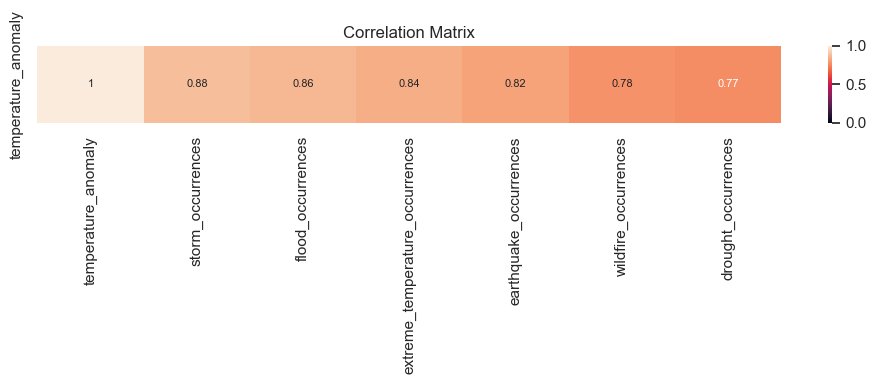

In [32]:
dis_global_yearly_count_wide_corr = dis_global_yearly_count_wide.drop('year', axis=1).corr(method='spearman')[['temperature_anomaly']]
plotTempDisCorrelation(dis_global_yearly_count_wide_corr)